<a href="https://colab.research.google.com/github/avinregmi/PyTorch-Lessons/blob/master/10.RNN%20My%20Own%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Generate Data

In [81]:
import numpy as np
import torch

n_steps = 75
print_every = 15
seq_length = 20

raw_data = np.zeros([75,21])
for batch_i, step in enumerate(range(n_steps)):
    # defining the training data 
    time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
    data = np.sin(time_steps)
    data.resize((seq_length + 1, 1)) # input_size=1
    x = data[0:-1]
    y = data[1:]

    raw_data[step] = data.reshape(21,)

#print('Starting Point:',step * np.pi, 'Stoping Poing:',(step+1)*np.pi, ' # of samples: ',seq_length )
time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1) #starting point, stoping point, # of samples to generate
print('Starting Point:',step * np.pi, 'Stoping Poing:',(step+1)*np.pi, ' # of samples: ',seq_length )

Starting Point: 232.4778563656447 Stoping Poing: 235.61944901923448  # of samples:  20


### Create a RNN model

In [0]:

class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, number_of_layers=1):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_dim = hidden_dim
    self.number_of_layers = number_of_layers

    self.rnn = nn.RNN(input_size, hidden_dim,number_of_layers,batch_first=True)

    self.fc = nn.Linear(hidden_dim, output_size)



  def forward(self, x, hidden):
    # x:(1,20,1) hidden:(1, 1, 32)


    # output_value: # of layers, batch, hidden_dim
    # hidden_value: # of layers, batch, hidden_dim
    output_value, hidden_value = self.rnn(x, hidden)

    # reshape output from RNN, before feeding into fc layer
    # reshape from (1,20,32) to (20,32)
    output_value = output_value.view(-1, self.hidden_dim)

    # pass into fc1
    # (20,32) x (32,1) = (20,1) 
    output = self.fc(output_value)

    # return output and hidden state
    return output, hidden_value


### Perform a dummy forward feed to inspect RNN dimension

In [122]:
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
output shape:  torch.Size([20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([1, 1, 32])


### Train a model

In [123]:
input_size = 1
output_size = 1
hidden_dim = 32
number_of_layers = 1

rnn = RNN(input_size,output_size,hidden_dim,number_of_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [0]:
#https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7
#MSE Loss because of Regression problems. The numerical value features are not large. Problem is not very high dimensional.

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(),lr=0.01)


Loss:  0.00035046032280661166


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 20, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


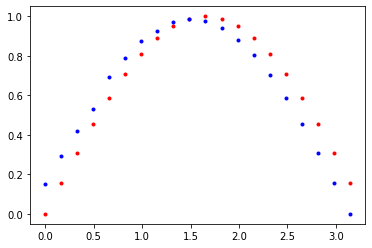

Loss:  7.935296162031591e-05


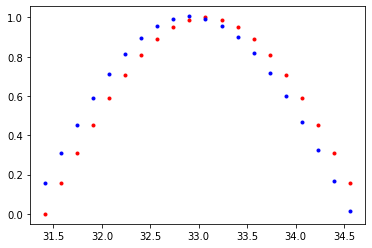

Loss:  3.161021595587954e-05


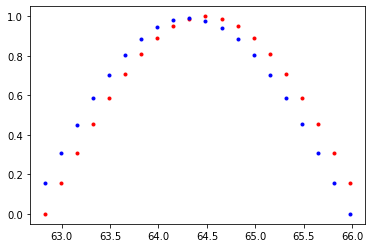

Loss:  2.1444428057293408e-05


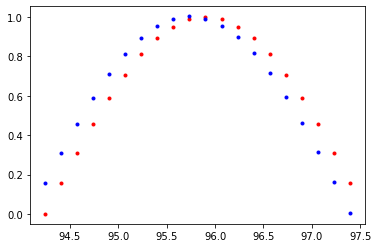

Loss:  4.162644017924322e-06


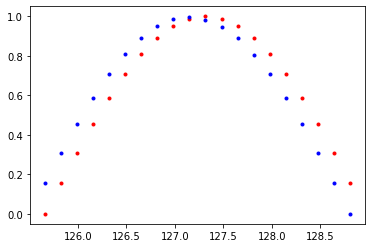

Loss:  9.045866704582295e-07


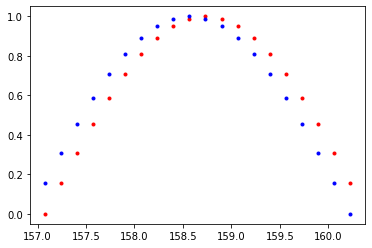

Loss:  7.474906738025311e-07


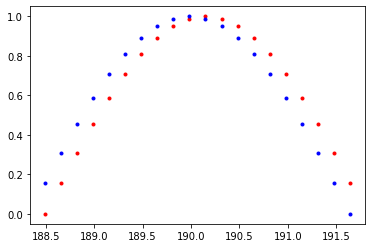

Loss:  6.967733270357712e-07


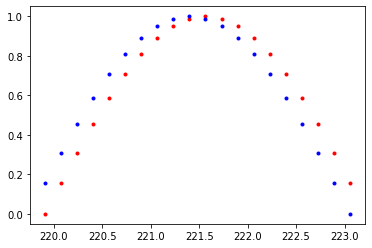

In [139]:
epochs = 1
iteration = 75

hidden = None

for epoch in range(epochs):
  for i in range(iteration):
    # Currently input is of type numpy and size is (21,0). We need to convert
    # into torch type with size of (1,20,1) [batch, seq_length, input_size]

    #convert from numpy to torch. Take all value, except the last one. As we're
    #trying to predict given input [0:20] is the output [1:21]
    #input_tensor shape: 1,20
    x_tensor = torch.from_numpy(raw_data[i][:-1]).float().view(1,20)

    # y_tensor will be from index [1:]
    y_tensor = torch.from_numpy(raw_data[i][1:]).float().view(1,20)

    # Currently, input_tensor shape is 1,20. Convert this shape to 1,20,1
    x_tensor = x_tensor.unsqueeze(2)
    y_tensor = y_tensor.unsqueeze(2)

    # forward feed into our model
    prediction, hidden = rnn(x_tensor,hidden)

    # make a new variable for hidden and detach the hidden state from its history
    # this way, we don't backpropagate through the entire history
    hidden = hidden.data

    # calculate the loss
    # (y_tensor - prediction)^2
    loss = criterion(prediction, y_tensor)

    # clear the gradient
    optimizer.zero_grad()

    # perform backward loss and update the weights
    loss.backward()
    optimizer.step()

    if(i%10 == 0):
      print('Loss: ',loss.item())
      time = np.linspace(i * np.pi, (i+1)*np.pi, 20)
      plt.plot(time, x.flatten(), 'r.') # input
      plt.plot(time, prediction.data.numpy().squeeze(1), 'b.') # predictions
      plt.show()




  


In [131]:
prediction.data.numpy().squeeze(1).shape

(20,)